In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nprand

# Street Racer

In this notebook, you'll apply the methods of chapter 3 of Sutton's book to a simple racing problem.

The problem consists in driving a car as fast of possible over an exact distance $L$, and stopping there.

This distance is divided in steps $0, ..., L$. The car can drive at three different speed: _low_, _medium_, _high_. Leaving step $j$ at _low_ speed, it will move to $j+1$. _Medium_ and _high_ bring it to $j+2$ and $j+3$, respectively.

At any step, the driver can decide to _decelerate_, _maintain speed_ or _accelerate_. Decelarating will cause the car to leave its current place at one speed lower. If the car is already at _low_ speed, decelarating keeps it in the same spot. Maintaining speed does exactly what you think. Accelerating will increase the speed by one, except at _high_ speed, where it is equivalent to maintaining speed.

The car starts on step $0$ at _low_ speed.

Beyond the $L$ distance there is a huge, hot lake of lava. Needless to say, the car must be able to stop at $L$, or the driver will suffer quite a lot.

To help the driver win the race and not die, build a model of the problem and apply the policy iteration and value iteration methods to find her optimal trajectory.

# Building the model

In [60]:
l = 20

In [61]:
# actions: decelerate, keep speed, accelerate
# differentiate states by incoming speed

speed_one = np.arange(l)
speed_two = np.arange(l, 2*l)
speed_three = np.arange(2*l, 3*l)
trap = 3*l
dim = 3*l+1
finish = l-1

In [62]:
T_decelerate = np.zeros(shape=(3*l+1, 3*l+1))
T_decelerate[3*l, 3*l] = 1

for s in speed_one:
    T_decelerate[s, s] = 1

for s in speed_two:
    if s < 2*l-1:
        T_decelerate[s, s-l+1] = 1
        T_decelerate[s, s+2] = 0
    else:
        T_decelerate[s, trap] = 1 
    

for s in speed_three:
    if s < 3*l-2:
        T_decelerate[s, s-l+2] = 1
        T_decelerate[s, s+3] = 0
    else:
        T_decelerate[s, trap] = 1

In [63]:
# building transition matrix for keep_speed
T_keep = np.zeros(shape=(dim, dim))
T_keep[trap, trap] = 1

for s in speed_one:
    if s == 0:
        T_keep[s, s] = 1
    elif s < l-1:
        T_keep[s, s+1] = 1
    else:
        T_keep[s, trap] = 1

for s in speed_two:
    if s < 2*l-2:
        T_keep[s, s+2] = 1
    else:
        T_keep[s, trap] = 1

for s in speed_three:
    if s < 3*l-3:
        T_keep[s, s+3] = 1
    else:
        T_keep[s, trap] = 1

In [64]:
T_acc = np.zeros(shape=(dim, dim))
T_acc[trap, trap] = 1

for s in speed_one:
    if s == 0:
        T_acc[s, s+1] = 1
    elif s < l-2:
        T_acc[s, s+l+2] = 1
    else:
        T_acc[s, trap] = 1

for s in speed_two:
    if s < 2*l-3:
        T_acc[s, s+l+3] = 1
    else:
        T_acc[s, trap] = 1

for s in speed_three:
    if s < 3*l-3:
        T_acc[s, s+3] = 1
    else:
        T_acc[s, trap] = 1

In [65]:
Ts = [T_decelerate, T_keep, T_acc]

# Solving for state value with system of eqs 

In [66]:
R = np.ones(dim)*-1

R[trap] = -25
R[l-1] = 1

In [67]:
T = (Ts[0]+Ts[1]+Ts[2])/3

In [68]:
value = np.dot(np.linalg.inv(np.eye(dim) - 0.9*T), np.transpose(R))

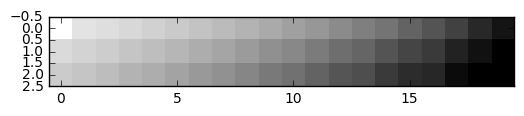

In [69]:
value = value[:trap].reshape(3, l)

plt.imshow(value, interpolation='nearest', cmap='gray')
plt.show()

# Q-Learning

In [70]:
def randargmax(array):
    candidates = np.where(array == max(array))[0]
    return np.random.choice(candidates)

def choose_at_random(epsilon):
    decision = [0, 1]
    proba = [1-epsilon, epsilon]
    return nprand.choice(decision, p=proba)

In [71]:
R = np.ones(dim)*-1

R[trap] = -25
R[l-1] = 1

In [72]:
Q = np.zeros(shape=(dim, 3))
alpha = 0.9
gamma = 0.6
epsilon = 0.1
eps = 1000
steps = 300
r_list = []
for ep in range(eps):
    s = 0
    ep_r = 0
    for step in range(steps):
        if choose_at_random(epsilon/((ep+1)/1)):
            a = nprand.choice(3)
        else:
            a = randargmax(Q[s, :])
        s_ = nprand.choice(np.where(Ts[a][s, :] > 0)[0])
        r = R[s_]
        Q[s, a] = (1-alpha)*Q[s, a] + alpha*(r + gamma*np.max(Q[s_, :]))
        s = s_
        ep_r += r
        if s == finish or s == trap:
            r_list.append(ep_r)
            break

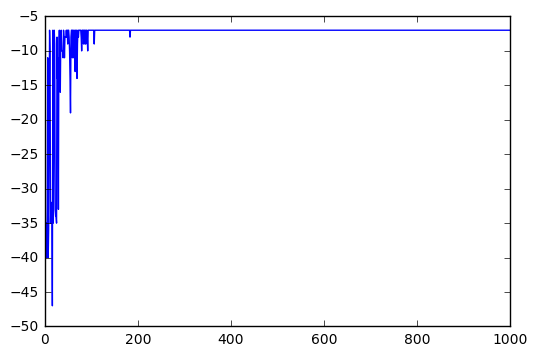

In [73]:
plt.plot(r_list)
plt.show()

# Policy iteration

In [74]:
def policy_eval(V, P, T, R, gamma, thresh):
    stop = 0
    while stop < 100:
        stop += 1
        delta = 0
        for s in range(len(V)):
            v = V[s]
            a = int(P[s])
            new_val = 0
            for s_ in range(len(V)):
                this_val = T[a][s, s_]*(R[s_] + gamma*V[s_])
                new_val += this_val
            V[s] = new_val
            delta = max(delta, np.abs(v - V[s]))
            
        if delta < thresh:
            return V
    return V

In [75]:
def policy_improv(V, P, A, T, R, gamma):
    stable = True
    for s in range(len(V)):
        #print(P)
        #print('state', s)
        old = int(P[s])
        #print('old1:', old)
        old_val = V[s]
        vals = []
        for a in A:
            this_val = 0
            for s_ in range(len(V)):
                #print('state', s_)
                new_val = T[a][s, s_]*(R[s_] + gamma*V[s_])
                #print(T[a][s, s_])
                this_val += new_val
            #print(this_val)
            vals.append(this_val)
        new = np.argmax(vals)
        #print('old2:', int(P[s]))
        v = max(vals)
        #print('new:', new)
        #print(' ')
        if old != new:
            #print("life's a biatch")
            P[s] = new
            stable = False
            return stable, V, P
        else:
            stable = True
    return stable, V, P

In [76]:
R = np.ones(dim)*-1

R[trap] = -25
R[l-1] = 5

In [77]:
P = np.zeros(dim)

V = np.zeros(dim)

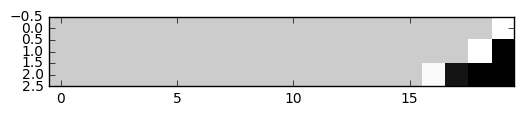

In [78]:
V = policy_eval(V, P, Ts, R, 0.9, 0.1)

V = V[:trap].reshape(3, l)

plt.imshow(V, interpolation='nearest', cmap='gray')
plt.show()

In [79]:
# policy iteration
stop = 100
V = np.zeros(dim)
P = np.zeros(dim)
sto = 0
gamma = 0.9
scores = []
values = []
while sto < 2000:
    sto += 1
    values.append(list(V))
    V = policy_eval(V, P, Ts, R, gamma, 0.01)
    stable, V, P = policy_improv(V, P, range(3), Ts, R, gamma)
    
    s = 0
    reward = 0
    trajec = [s]
    actions = []
    steps = 0
    while steps < l+1:
        steps += 1
        a = int(P[s])
        s = nprand.choice(np.where(Ts[a][s, :] > 0)[0])
        trajec.append(s)
        reward += R[s]
        if s == finish or s == trap:
            break
    
    scores.append(reward)
    if stable and reward >= max(scores):
        print('converged')
        break
print(sto)
print(trajec)

converged
99
[0, 1, 23, 46, 28, 51, 33, 56, 38, 19]


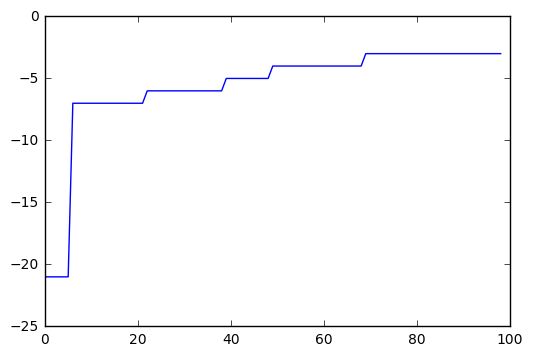

In [80]:
plt.plot(scores)
plt.show()

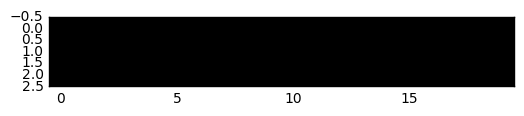

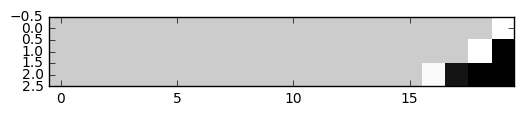

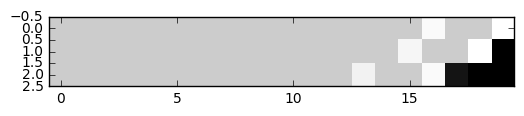

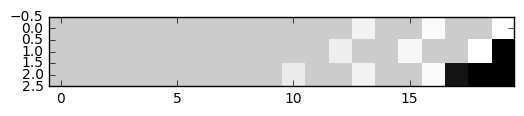

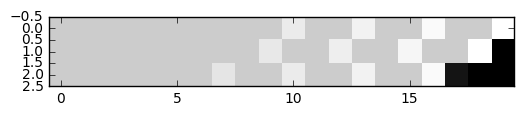

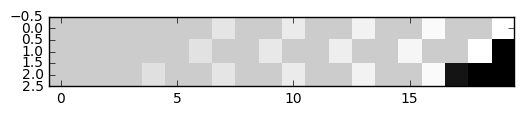

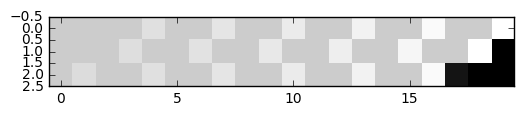

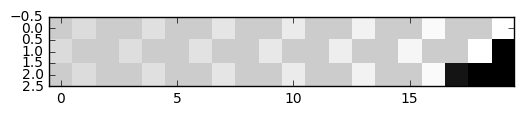

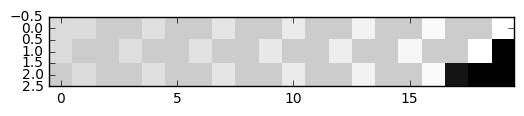

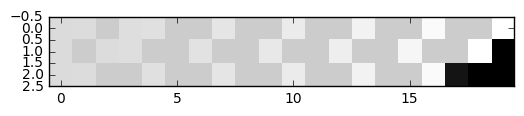

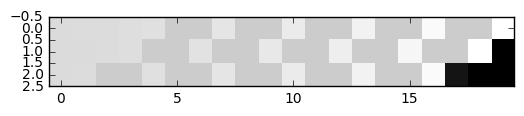

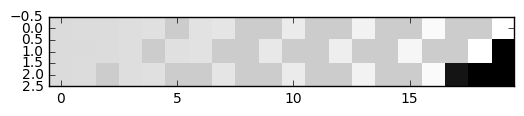

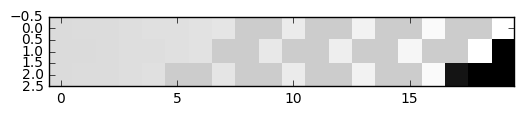

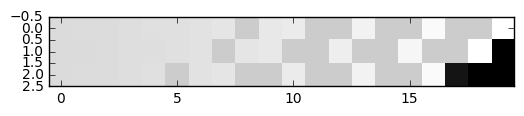

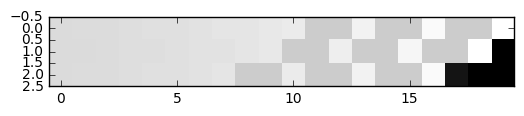

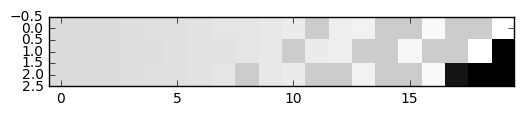

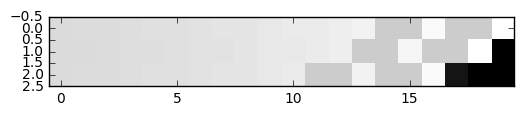

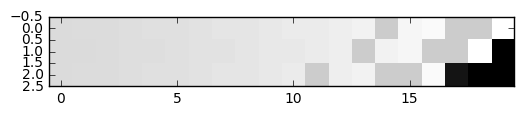

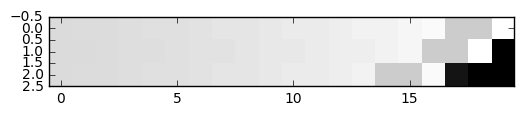

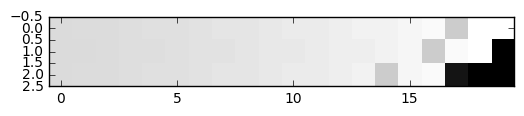

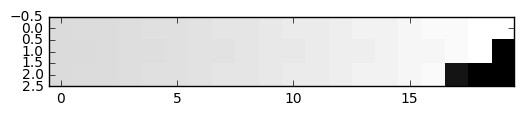

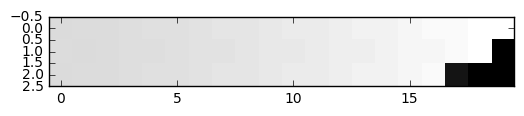

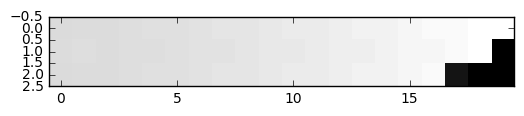

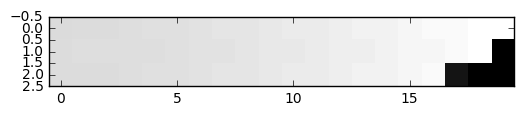

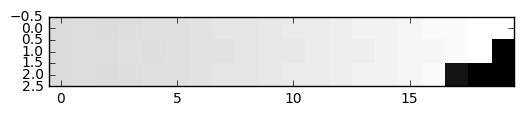

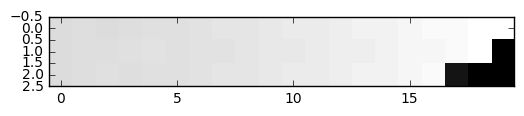

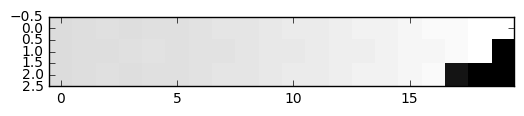

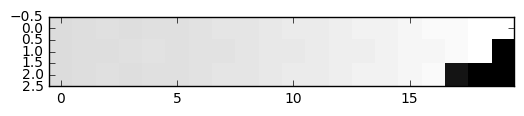

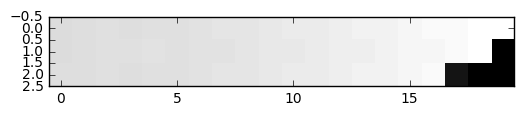

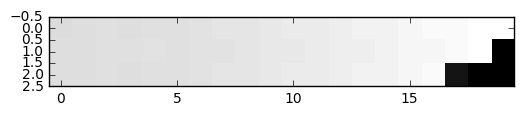

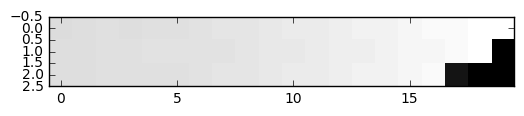

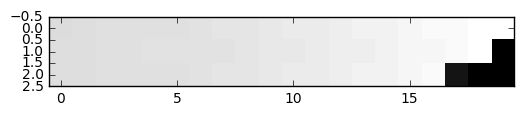

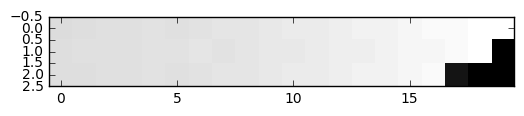

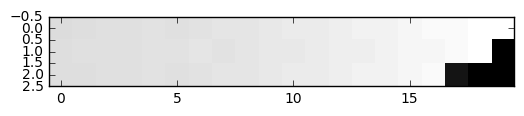

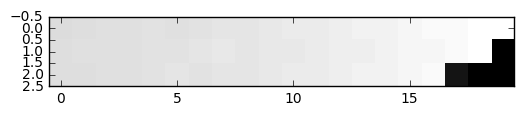

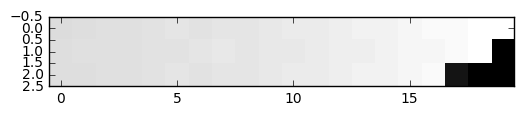

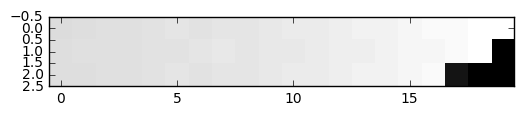

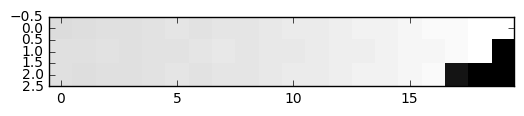

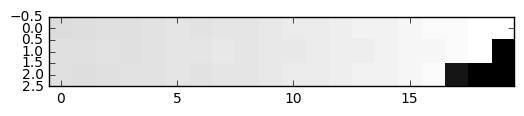

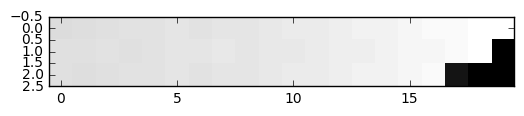

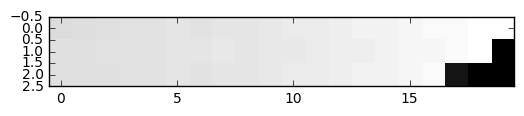

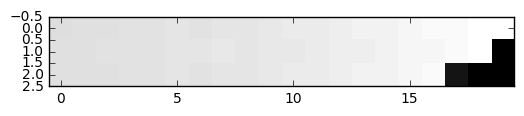

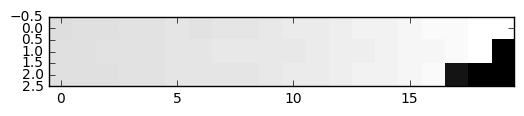

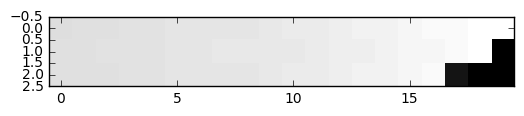

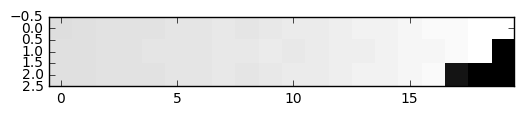

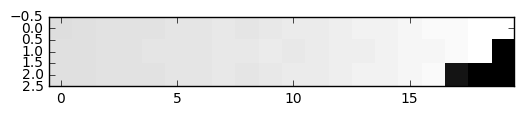

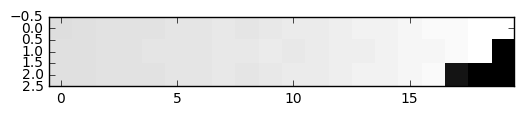

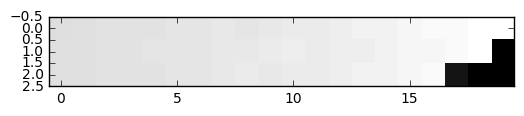

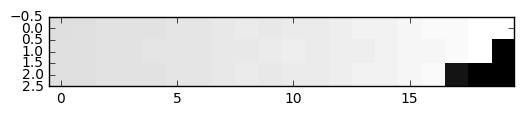

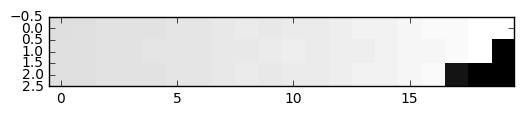

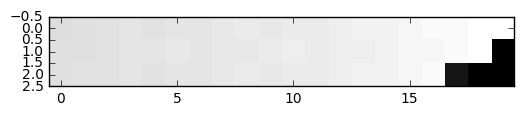

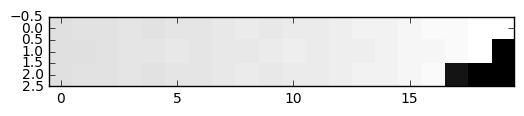

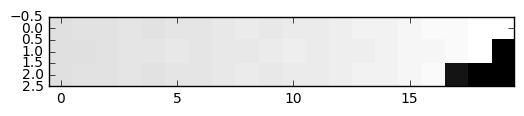

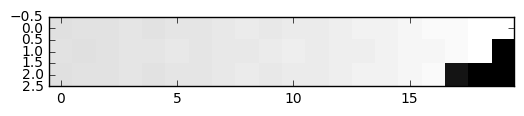

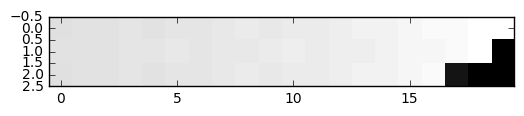

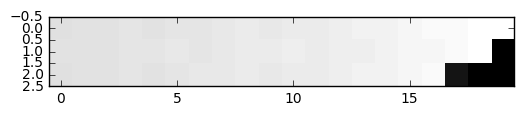

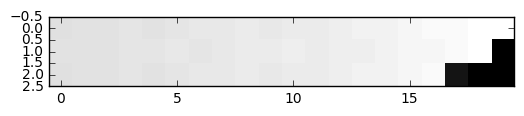

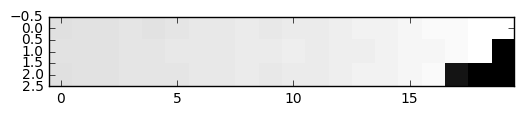

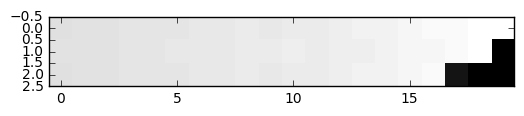

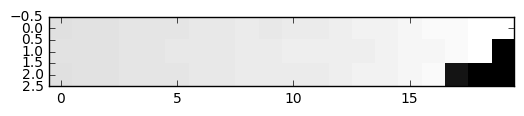

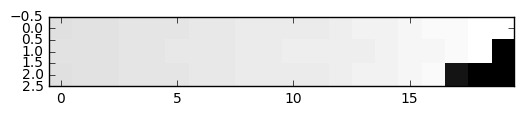

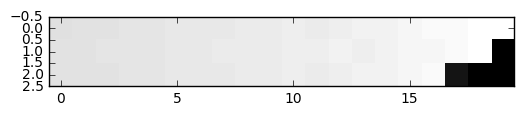

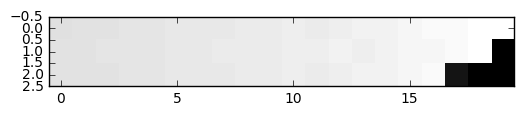

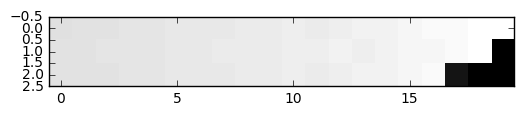

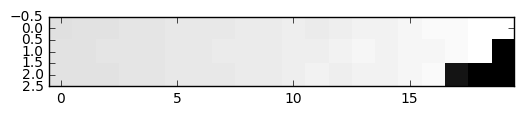

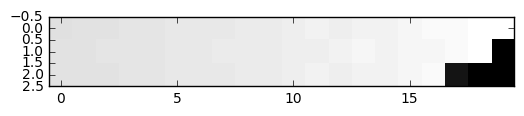

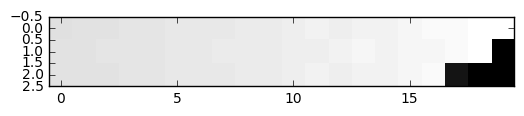

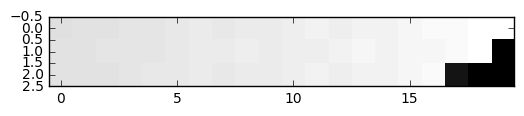

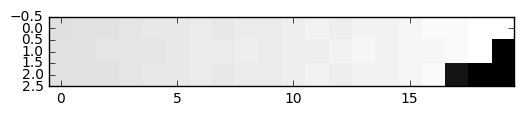

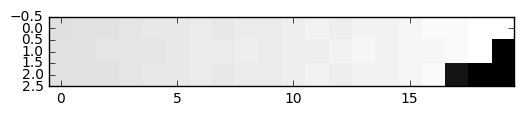

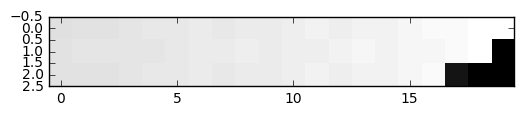

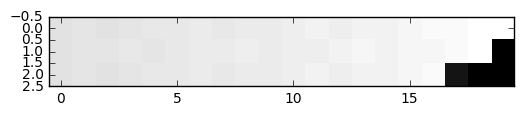

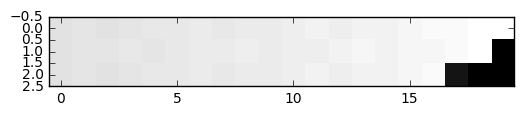

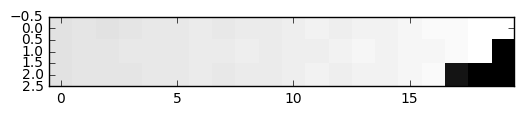

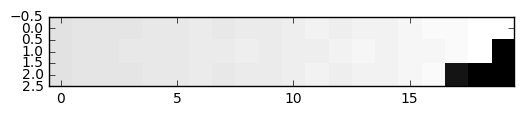

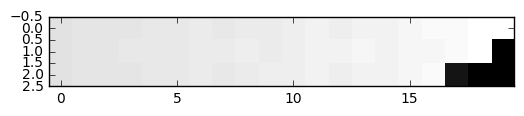

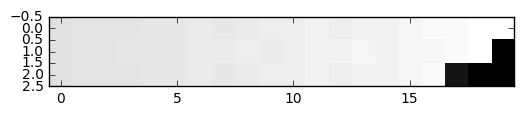

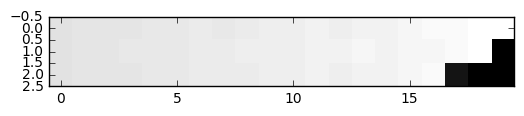

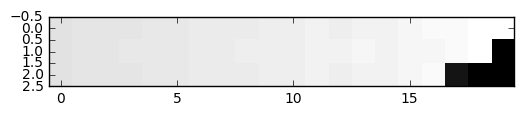

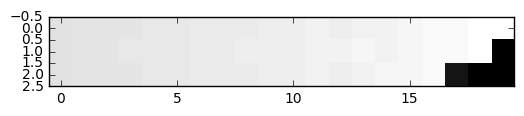

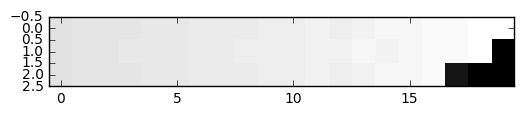

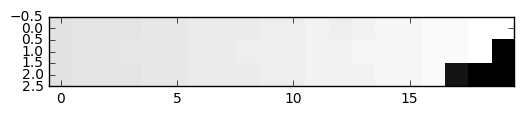

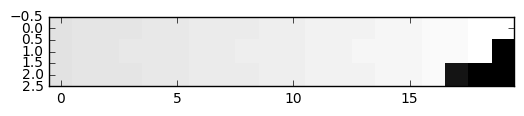

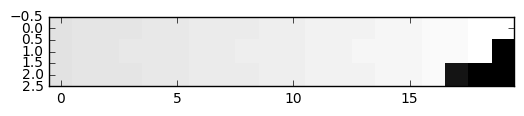

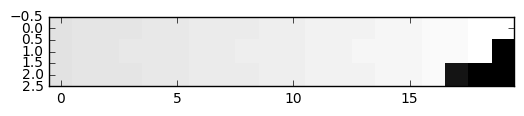

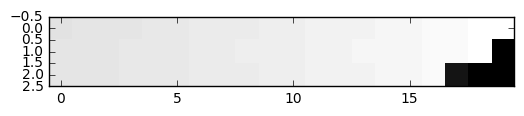

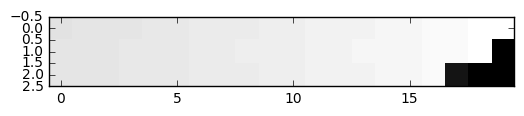

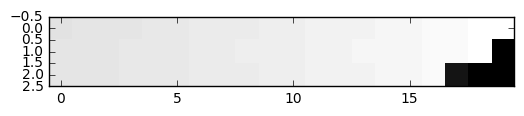

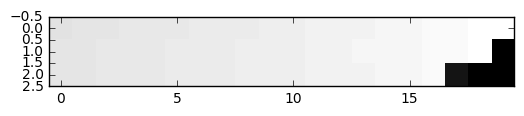

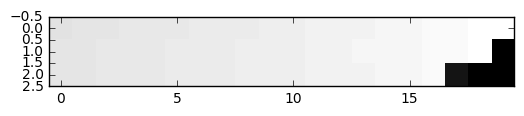

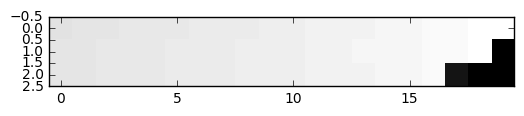

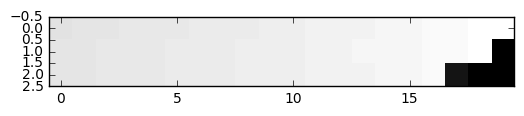

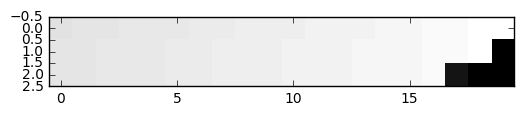

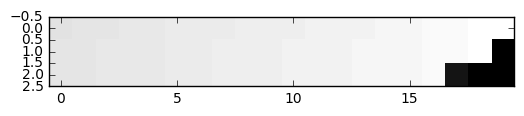

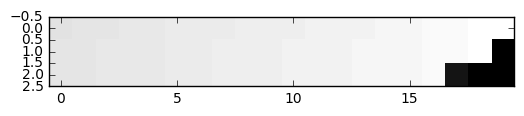

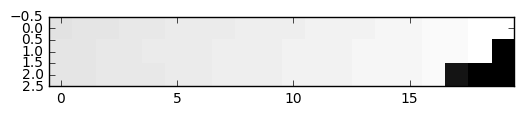

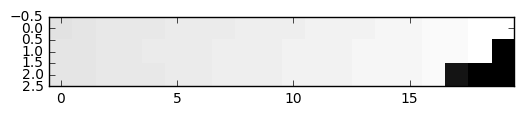

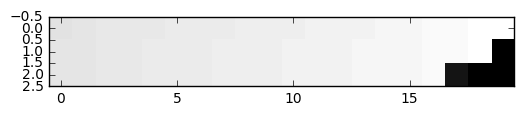

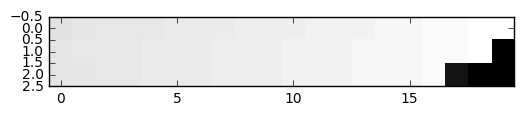

In [81]:
for v in values:
    v = np.array(v[:trap]).reshape(3, l)

    plt.imshow(v, interpolation='nearest', cmap='gray')
    plt.show()